In [1]:
import argparse
from itertools import combinations

import numpy as np
from scipy.linalg import eigh

import cirq
from openfermion.ops import MajoranaOperator
from openfermion.transforms import jordan_wigner
from openfermion.linalg import get_sparse_operator

import torch 

import numpy as np
from qiskit import Aer
from qiskit.utils import QuantumInstance
from qiskit.circuit import QuantumCircuit, ParameterVector, Parameter
from qiskit.algorithms import VQE, NumPyMinimumEigensolver
from qiskit.algorithms.optimizers import SPSA, ADAM
from qiskit.opflow import MatrixOp
import warnings
from qiskit.circuit.library import RZGate, RXGate, RXXGate
from math import pi

warnings.filterwarnings('ignore')

def factorial(n):
    if n == 1:
        return 1
    return n * factorial(n-1)

def get_couplings(N, var, L_inds, R_inds, seed, q):
    """Returns dictionaries of hamiltonian terms and their coefficients"""
    np.random.seed(seed)
    couplings = np.random.normal(scale=np.sqrt(var), size=len(L_inds))
    phase = (-1)**(q/2)
    J_L = {i: c for i, c in zip(L_inds, couplings)}
    J_R = {i: phase * c for i, c in zip(R_inds, couplings)}
    return J_L, J_R

def convert_H_majorana_to_qubit(inds, J_dict, N):
    """Convert SYK hamiltonian (dictionary) from majorana terms to Pauli terms"""
    ham_terms = [MajoranaOperator(ind, J_dict[ind]) for ind in inds]
    ham_sum = sum_ops(ham_terms)
    return jordan_wigner(ham_sum)

def q_helper(idx):
    """Returns qubit object based on index"""
    return cirq.LineQubit(idx)

def construct_pauli_string(ham, key):
    """Converts Pauli terms in the Hamiltonian to a string representation"""
    gate_dict = {'X': cirq.X, 'Y': cirq.Y, 'Z': cirq.Z}

    def list_of_terms(key):
        return [gate_dict[label](q_helper(idx)) for (idx, label) in key]

    return cirq.PauliString(ham.terms[key], list_of_terms(key))

def sum_ops(operators):
    """Wrapper for summing a list of majorana operators"""
    return sum(operators, MajoranaOperator((), 0))

def gs_energy(hamiltonian):
    """Use scipy to get the ground state energy"""
    from scipy.linalg import eigvalsh
    return eigvalsh(hamiltonian, eigvals=(0,0))

def main(N, seed, mu):
    q = 4 # setting q = N is all to all connectivity
    J = 1 # overall coupling strength

    J_var = 2**(q-1) * J**2 * factorial(q-1) / (q * N**(q-1))

    L_indices = range(0, N)
    R_indices = range(N, 2 * N)
    SYK_L_indices = list(combinations(L_indices, q))
    SYK_R_indices = list(combinations(R_indices, q))
    interaction_indices = [(l, r) for l, r in zip(L_indices, R_indices)]

    J_L, J_R = get_couplings(N, J_var, SYK_L_indices, SYK_R_indices, seed, q)
    interaction_strength = {ind: 1j * mu for ind in interaction_indices}

    H_L = convert_H_majorana_to_qubit(SYK_L_indices, J_L, N)
    H_R = convert_H_majorana_to_qubit(SYK_R_indices, J_R, N)
    H_int = convert_H_majorana_to_qubit(interaction_indices, interaction_strength, N)

    total_ham = H_L + H_R + H_int

    matrix_ham = get_sparse_operator(total_ham)
    return matrix_ham.todense()

N=8
seed= 0
mu= 0.01
hamiltonian_matrix = main(N,seed, mu)
#hamiltonian_matrix= torch.tensor(hamiltonian_matrix)

print(len(hamiltonian_matrix))



# Convert the dense Hamiltonian matrix to a suitable operator for VQE
hamiltonian_operator = MatrixOp(hamiltonian_matrix)


# Define a simple parameterized circuit as the ansatz
def create_ansatz(num_qubits):
    depth=4
    # Define the number of parameters for the rotation gates
    num_params_per_rotation_layer = 3 * num_qubits
    # Define the number of parameters for the RXX gates
    num_params_per_rxx_layer = num_qubits // 2
    # Calculate the total number of parameters per layer
    num_params_per_layer = num_params_per_rotation_layer + num_params_per_rxx_layer
    # Calculate the total number of parameters for all layers
    total_params = depth * num_params_per_layer

    # Initialize the parameter vector
    params = ParameterVector('θ', length=total_params)
    # Create the quantum circuit
    qc = QuantumCircuit(num_qubits)
    param_counter = 0  # Counter for the parameters

    # Construct the layers
    for layer in range(depth):
        # Add rotation layers
        for qubit in range(num_qubits):
            qc.rz(params[param_counter], qubit)
            param_counter += 1
            qc.rx(params[param_counter], qubit)
            param_counter += 1
            qc.rz(params[param_counter], qubit)
            param_counter += 1
        
        # Add the RXX gates for the even layers
        if layer % 2 == 0:
            for qubit in range(0, num_qubits - 1, 2):
                qc.rxx(params[param_counter], qubit, qubit + 1)
                param_counter += 1
        # Add the RXX gates for the odd layers
        else:
            for qubit in range(1, num_qubits - 1, 2):
                qc.rxx(params[param_counter], qubit, qubit + 1)
                param_counter += 1

    return qc, params



num_qubits = int(np.log2(hamiltonian_matrix.shape[0]))
ansatz, parameters = create_ansatz(num_qubits)

# Use SPSA optimizer, it's suitable for noisy optimization like on a real quantum device
optimizer = ADAM(maxiter=1000)

# Setup quantum instance to use the statevector simulator
quantum_instance = QuantumInstance(Aer.get_backend('aer_simulator_statevector'))

# Initialize VQE with the ansatz, optimizer, and the quantum instance
vqe = VQE(ansatz=ansatz, optimizer=optimizer, quantum_instance=quantum_instance)

# Run VQE to find the lowest eigenvalue of the Hamiltonian
vqe_result = vqe.compute_minimum_eigenvalue(operator=hamiltonian_operator)

# Extract the lowest eigenvaluef
lowest_eigenvalue = np.real(vqe_result.eigenvalue)
print("The VQE given lowest eigenvalue is: ", lowest_eigenvalue)

# Compare to exact solver
exact_solver = NumPyMinimumEigensolver()
exact_result = exact_solver.compute_minimum_eigenvalue(operator=hamiltonian_operator)

print('Exact Solver Result:', exact_result.eigenvalue.real)


/var/folders/xw/9h0k4l0555nf2zvvvddq0hm00000gn/T/ipykernel_66486/3608205232.py:18: DeprecationWarning: ``qiskit.algorithms`` has been migrated to an independent package: https://github.com/qiskit-community/qiskit-algorithms. The ``qiskit.algorithms`` import path is deprecated as of qiskit-terra 0.25.0 and will be removed no earlier than 3 months after the release date. Please run ``pip install qiskit_algorithms`` and use ``import qiskit_algorithms`` instead.
  from qiskit.algorithms import VQE, NumPyMinimumEigensolver


256
The VQE given lowest eigenvalue is:  -3.6969903421119774
Exact Solver Result: -5.3155751414375985


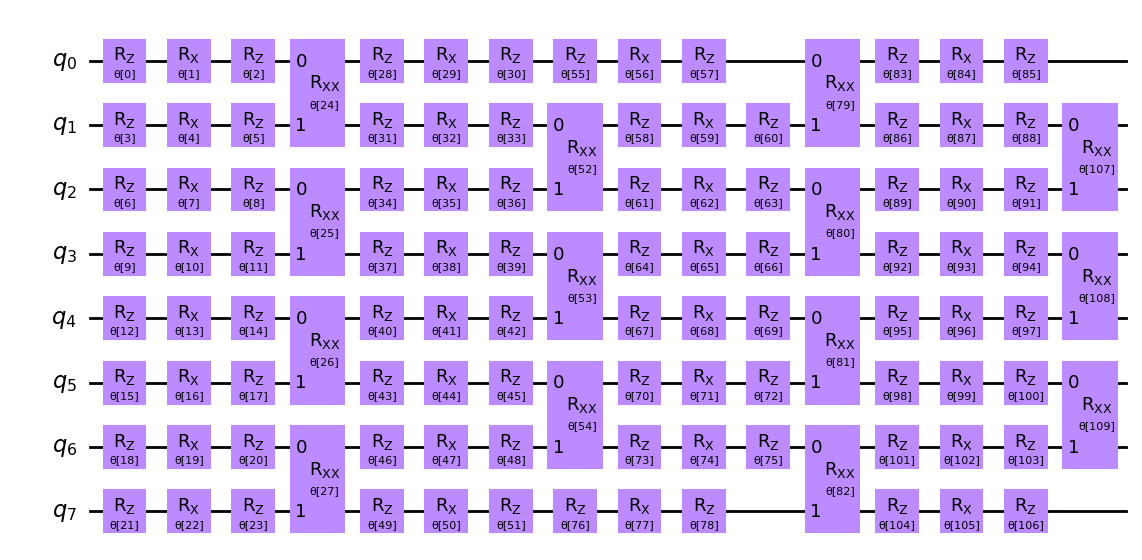

In [2]:
ansatz_circuit, _ = create_ansatz(num_qubits)
ansatz_circuit.draw('mpl')

In [3]:
import argparse
from itertools import combinations

import numpy as np
from scipy.linalg import eigh

import cirq
from openfermion.ops import MajoranaOperator
from openfermion.transforms import jordan_wigner
from openfermion.linalg import get_sparse_operator

import torch 

import numpy as np
from qiskit import Aer
from qiskit.utils import QuantumInstance
from qiskit.circuit import QuantumCircuit, ParameterVector, Parameter
from qiskit.algorithms import VQE, NumPyMinimumEigensolver
from qiskit.algorithms.optimizers import SPSA, ADAM
from qiskit.opflow import MatrixOp
import warnings
from qiskit.circuit.library import RZGate, RXGate, RXXGate
from math import pi

warnings.filterwarnings('ignore')

def factorial(n):
    if n == 1:
        return 1
    return n * factorial(n-1)

def get_couplings(N, var, L_inds, R_inds, seed, q):
    """Returns dictionaries of hamiltonian terms and their coefficients"""
    np.random.seed(seed)
    couplings = np.random.normal(scale=np.sqrt(var), size=len(L_inds))
    phase = (-1)**(q/2)
    J_L = {i: c for i, c in zip(L_inds, couplings)}
    J_R = {i: phase * c for i, c in zip(R_inds, couplings)}
    return J_L, J_R

def convert_H_majorana_to_qubit(inds, J_dict, N):
    """Convert SYK hamiltonian (dictionary) from majorana terms to Pauli terms"""
    ham_terms = [MajoranaOperator(ind, J_dict[ind]) for ind in inds]
    ham_sum = sum_ops(ham_terms)
    return jordan_wigner(ham_sum)

def q_helper(idx):
    """Returns qubit object based on index"""
    return cirq.LineQubit(idx)

def construct_pauli_string(ham, key):
    """Converts Pauli terms in the Hamiltonian to a string representation"""
    gate_dict = {'X': cirq.X, 'Y': cirq.Y, 'Z': cirq.Z}

    def list_of_terms(key):
        return [gate_dict[label](q_helper(idx)) for (idx, label) in key]

    return cirq.PauliString(ham.terms[key], list_of_terms(key))

def sum_ops(operators):
    """Wrapper for summing a list of majorana operators"""
    return sum(operators, MajoranaOperator((), 0))

def gs_energy(hamiltonian):
    """Use scipy to get the ground state energy"""
    from scipy.linalg import eigvalsh
    return eigvalsh(hamiltonian, eigvals=(0,0))

def main(N, seed, mu):
    q = 4 # setting q = N is all to all connectivity
    J = 1 # overall coupling strength

    J_var = 2**(q-1) * J**2 * factorial(q-1) / (q * N**(q-1))

    L_indices = range(0, N)
    R_indices = range(N, 2 * N)
    SYK_L_indices = list(combinations(L_indices, q))
    SYK_R_indices = list(combinations(R_indices, q))
    interaction_indices = [(l, r) for l, r in zip(L_indices, R_indices)]

    J_L, J_R = get_couplings(N, J_var, SYK_L_indices, SYK_R_indices, seed, q)
    interaction_strength = {ind: 1j * mu for ind in interaction_indices}

    H_L = convert_H_majorana_to_qubit(SYK_L_indices, J_L, N)
    H_R = convert_H_majorana_to_qubit(SYK_R_indices, J_R, N)
    H_int = convert_H_majorana_to_qubit(interaction_indices, interaction_strength, N)

    total_ham = H_L + H_R + H_int

    matrix_ham = get_sparse_operator(total_ham)
    return matrix_ham.todense()

N=8
seed= 0
mu= 0.01
hamiltonian_matrix = main(N,seed, mu)
#hamiltonian_matrix= torch.tensor(hamiltonian_matrix)

print(len(hamiltonian_matrix))



# Convert the dense Hamiltonian matrix to a suitable operator for VQE
hamiltonian_operator = MatrixOp(hamiltonian_matrix)


from qiskit.circuit import QuantumCircuit, ParameterVector

def create_ansatz(num_qubits):
    depth = 4
    # Define the number of parameters for the rotation gates
    num_params_per_rotation_layer = 3 * num_qubits
    # Define the number of parameters for the RXX gates
    num_params_per_rxx_layer = num_qubits // 2
    # Calculate the total number of parameters per layer
    num_params_per_layer = num_params_per_rotation_layer + num_params_per_rxx_layer
    # Calculate the total number of parameters for all layers
    total_params = depth * num_params_per_layer

    # Initialize the parameter vector
    params = ParameterVector('θ', length=total_params)
    # Create the quantum circuit
    qc = QuantumCircuit(num_qubits)
    
    # Initialize counters for Rz and other gates separately
    rz_param_counter = 0
    other_param_counter = num_qubits * depth

    # Construct the layers
    for layer in range(depth):
        # Add rotation layers
        for qubit in range(num_qubits):
            # Rz gates are numbered sequentially across all layers
            qc.rz(params[rz_param_counter], qubit)
            rz_param_counter += 1
            
            # Rx and second Rz use a different counter
            qc.rx(params[other_param_counter], qubit)
            other_param_counter += 1
            qc.rz(params[other_param_counter], qubit)
            other_param_counter += 1
        
        # Add the RXX gates for the even layers
        if layer % 2 == 0:
            for qubit in range(0, num_qubits - 1, 2):
                qc.rxx(params[other_param_counter], qubit, qubit + 1)
                other_param_counter += 1
        # Add the RXX gates for the odd layers
        else:
            for qubit in range(1, num_qubits - 1, 2):
                qc.rxx(params[other_param_counter], qubit, qubit + 1)
                other_param_counter += 1

    return qc, params




num_qubits = int(np.log2(hamiltonian_matrix.shape[0]))
ansatz, parameters = create_ansatz(num_qubits)

# Use SPSA optimizer, it's suitable for noisy optimization like on a real quantum device
optimizer = SPSA(maxiter=1000)

# Setup quantum instance to use the statevector simulator
quantum_instance = QuantumInstance(Aer.get_backend('aer_simulator_statevector'))

# Initialize VQE with the ansatz, optimizer, and the quantum instance
vqe = VQE(ansatz=ansatz, optimizer=optimizer, quantum_instance=quantum_instance)

# Run VQE to find the lowest eigenvalue of the Hamiltonian
vqe_result = vqe.compute_minimum_eigenvalue(operator=hamiltonian_operator)

# Extract the lowest eigenvaluef
lowest_eigenvalue = np.real(vqe_result.eigenvalue)
print("The VQE given lowest eigenvalue is: ", lowest_eigenvalue)

# Compare to exact solver
exact_solver = NumPyMinimumEigensolver()
exact_result = exact_solver.compute_minimum_eigenvalue(operator=hamiltonian_operator)

print('Exact Solver Result:', exact_result.eigenvalue.real)


256
The VQE given lowest eigenvalue is:  -3.543689260433199
Exact Solver Result: -5.315575141437612


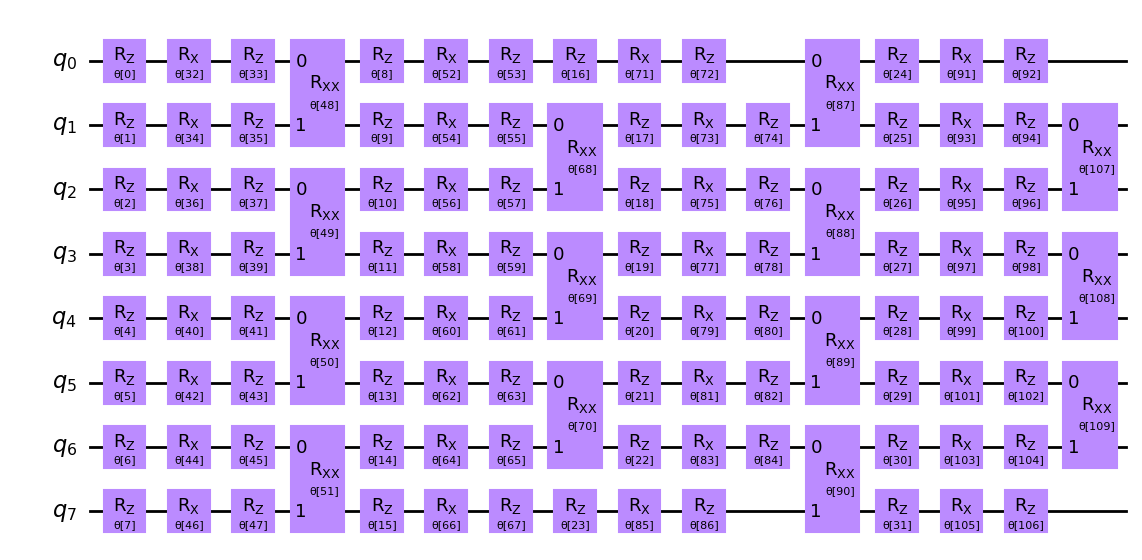

In [4]:
ansatz_circuit, _ = create_ansatz(num_qubits)
ansatz_circuit.draw('mpl')

In [5]:
"""

def create_ansatz(num_qubits):
    depth=4
    # Each layer has 3 rotations per qubit and half the number of qubits RXX gates
    num_params_per_rotation_layer = 3 * num_qubits
    num_params_per_rxx_layer = num_qubits // 2
    num_params_per_layer = num_params_per_rotation_layer + num_params_per_rxx_layer
    total_params = depth * num_params_per_layer

    # Create a list of parameters
    params = [Parameter(f'θ{i}') for i in range(total_params)]
    qc = QuantumCircuit(num_qubits)

    # Assign parameters layer by layer
    for layer in range(depth):
        # Assign parameters for rotation gates
        for qubit in range(num_qubits):
            param_idx = layer * num_params_per_layer + qubit * 3
            qc.rz(params[param_idx], qubit)
            qc.rx(params[param_idx + 1], qubit)
            qc.rz(params[param_idx + 2], qubit)

        # Assign parameters for RXX gates in the layer
        for qubit in range(0, num_qubits, 2):
            param_idx = layer * num_params_per_layer + num_params_per_rotation_layer + qubit // 2
            qc.rxx(params[param_idx], qubit, qubit + 1)

    return qc, params
"""

"\n\ndef create_ansatz(num_qubits):\n    depth=4\n    # Each layer has 3 rotations per qubit and half the number of qubits RXX gates\n    num_params_per_rotation_layer = 3 * num_qubits\n    num_params_per_rxx_layer = num_qubits // 2\n    num_params_per_layer = num_params_per_rotation_layer + num_params_per_rxx_layer\n    total_params = depth * num_params_per_layer\n\n    # Create a list of parameters\n    params = [Parameter(f'θ{i}') for i in range(total_params)]\n    qc = QuantumCircuit(num_qubits)\n\n    # Assign parameters layer by layer\n    for layer in range(depth):\n        # Assign parameters for rotation gates\n        for qubit in range(num_qubits):\n            param_idx = layer * num_params_per_layer + qubit * 3\n            qc.rz(params[param_idx], qubit)\n            qc.rx(params[param_idx + 1], qubit)\n            qc.rz(params[param_idx + 2], qubit)\n\n        # Assign parameters for RXX gates in the layer\n        for qubit in range(0, num_qubits, 2):\n            param

In [6]:
import argparse
from itertools import combinations

import numpy as np
from scipy.linalg import eigh

import cirq
from openfermion.ops import MajoranaOperator
from openfermion.transforms import jordan_wigner
from openfermion.linalg import get_sparse_operator

import torch 

import numpy as np
from qiskit import Aer
from qiskit.utils import QuantumInstance
from qiskit.circuit import QuantumCircuit, ParameterVector, Parameter
from qiskit.algorithms import VQE, NumPyMinimumEigensolver
from qiskit.algorithms.optimizers import SPSA, ADAM
from qiskit.opflow import MatrixOp
import warnings
from qiskit.circuit.library import RZGate, RXGate, RXXGate
from math import pi

warnings.filterwarnings('ignore')

def factorial(n):
    if n == 1:
        return 1
    return n * factorial(n-1)

def get_couplings(N, var, L_inds, R_inds, seed, q):
    """Returns dictionaries of hamiltonian terms and their coefficients"""
    np.random.seed(seed)
    couplings = np.random.normal(scale=np.sqrt(var), size=len(L_inds))
    phase = (-1)**(q/2)
    J_L = {i: c for i, c in zip(L_inds, couplings)}
    J_R = {i: phase * c for i, c in zip(R_inds, couplings)}
    return J_L, J_R

def convert_H_majorana_to_qubit(inds, J_dict, N):
    """Convert SYK hamiltonian (dictionary) from majorana terms to Pauli terms"""
    ham_terms = [MajoranaOperator(ind, J_dict[ind]) for ind in inds]
    ham_sum = sum_ops(ham_terms)
    return jordan_wigner(ham_sum)

def q_helper(idx):
    """Returns qubit object based on index"""
    return cirq.LineQubit(idx)

def construct_pauli_string(ham, key):
    """Converts Pauli terms in the Hamiltonian to a string representation"""
    gate_dict = {'X': cirq.X, 'Y': cirq.Y, 'Z': cirq.Z}

    def list_of_terms(key):
        return [gate_dict[label](q_helper(idx)) for (idx, label) in key]

    return cirq.PauliString(ham.terms[key], list_of_terms(key))

def sum_ops(operators):
    """Wrapper for summing a list of majorana operators"""
    return sum(operators, MajoranaOperator((), 0))

def gs_energy(hamiltonian):
    """Use scipy to get the ground state energy"""
    from scipy.linalg import eigvalsh
    return eigvalsh(hamiltonian, eigvals=(0,0))

def main(N, seed, mu):
    q = 4 # setting q = N is all to all connectivity
    J = 1 # overall coupling strength

    J_var = 2**(q-1) * J**2 * factorial(q-1) / (q * N**(q-1))

    L_indices = range(0, N)
    R_indices = range(N, 2 * N)
    SYK_L_indices = list(combinations(L_indices, q))
    SYK_R_indices = list(combinations(R_indices, q))
    interaction_indices = [(l, r) for l, r in zip(L_indices, R_indices)]

    J_L, J_R = get_couplings(N, J_var, SYK_L_indices, SYK_R_indices, seed, q)
    interaction_strength = {ind: 1j * mu for ind in interaction_indices}

    H_L = convert_H_majorana_to_qubit(SYK_L_indices, J_L, N)
    H_R = convert_H_majorana_to_qubit(SYK_R_indices, J_R, N)
    H_int = convert_H_majorana_to_qubit(interaction_indices, interaction_strength, N)

    total_ham = H_L + H_R + H_int

    matrix_ham = get_sparse_operator(total_ham)
    return matrix_ham.todense()

N=8
seed= 0
mu= 0.01
hamiltonian_matrix = main(N,seed, mu)
#hamiltonian_matrix= torch.tensor(hamiltonian_matrix)

print(len(hamiltonian_matrix))



# Convert the dense Hamiltonian matrix to a suitable operator for VQE
hamiltonian_operator = MatrixOp(hamiltonian_matrix)


# Define a simple parameterized circuit as the ansatz
def create_ansatz(num_qubits):
    depth=4
    # Define the total number of parameters, accounting for rotations and Rxx gates
    num_rotation_params = 3 * num_qubits * depth
    num_rxx_params = depth * (num_qubits - 1)  # One Rxx gate between each pair per layer
    total_params = num_rotation_params + num_rxx_params

    # Initialize the parameter vector
    params = ParameterVector('θ', length=total_params)
    qc = QuantumCircuit(num_qubits)
    param_counter = 0  # Counter for the parameters

    # Construct the layers
    for layer in range(depth):
        # Add rotation layers
        for qubit in range(num_qubits):
            qc.rz(params[param_counter], qubit)
            param_counter += 1
            qc.rx(params[param_counter], qubit)
            param_counter += 1
            qc.rz(params[param_counter], qubit)
            param_counter += 1
        
        # Add the Rxx gates for the layer, creating a 'staircase' pattern
        for qubit in range(0, num_qubits - 1):
            # Skip the connection to create the staircase pattern
            if layer % 2 == 0 and qubit % 2 == 0:
                continue
            if layer % 2 == 1 and qubit % 2 == 1:
                continue
            # Apply the Rxx gate
            qc.rxx(params[param_counter], qubit, qubit + 1)
            param_counter += 1


    return qc, params



num_qubits = int(np.log2(hamiltonian_matrix.shape[0]))
ansatz, parameters = create_ansatz(num_qubits)

# Use SPSA optimizer, it's suitable for noisy optimization like on a real quantum device
optimizer = ADAM(maxiter=1000)

# Setup quantum instance to use the statevector simulator
quantum_instance = QuantumInstance(Aer.get_backend('aer_simulator_statevector'))

# Initialize VQE with the ansatz, optimizer, and the quantum instance
vqe = VQE(ansatz=ansatz, optimizer=optimizer, quantum_instance=quantum_instance)

# Run VQE to find the lowest eigenvalue of the Hamiltonian
vqe_result = vqe.compute_minimum_eigenvalue(operator=hamiltonian_operator)

# Extract the lowest eigenvalue
lowest_eigenvalue = np.real(vqe_result.eigenvalue)
print("The VQE given lowest eigenvalue is: ", lowest_eigenvalue)

# Compare to exact solver
exact_solver = NumPyMinimumEigensolver()
exact_result = exact_solver.compute_minimum_eigenvalue(operator=hamiltonian_operator)

print('Exact Solver Result:', exact_result.eigenvalue.real)


256
The VQE given lowest eigenvalue is:  -4.295473155443613
Exact Solver Result: -5.315575141437612


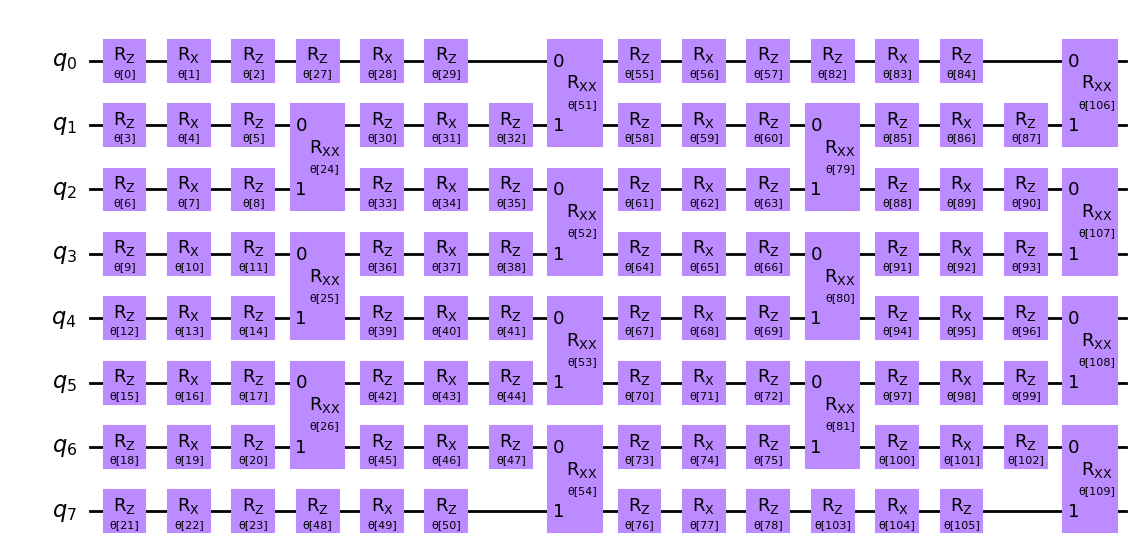

In [7]:
ansatz_circuit, _ = create_ansatz(num_qubits)
ansatz_circuit.draw('mpl')


In [8]:
from qiskit import QuantumCircuit
from qiskit.circuit import Parameter
from qiskit.circuit.library.standard_gates import RXXGate

def create_tfd_ansatz(num_qubits, depth):
    # Create a parameter for each rotation gate and RXX gate
    total_params = 3 * num_qubits * depth  # Rotation gates
    # Assuming the depth is 1 for the pattern to match the given circuit
    rxx_params = num_qubits - 1  # RXX gates per layer
    total_params += rxx_params * depth
    
    # Initialize the quantum circuit for n qubits
    circuit = QuantumCircuit(num_qubits)
    params = [Parameter(f'θ{i}') for i in range(total_params)]
    param_counter = 0
    
    for d in range(depth):
        # Apply Rz, Rx, Rz rotations to each qubit
        for q in range(num_qubits):
            circuit.rz(params[param_counter], q)
            param_counter += 1
            circuit.rx(params[param_counter], q)
            param_counter += 1
            circuit.rz(params[param_counter], q)
            param_counter += 1
        
        # Apply RXX gates in the interleaved "zipper" pattern
        for q in range(0, num_qubits - 1):
            if (d % 2 == 0 and q % 2 == 0) or (d % 2 == 1 and q % 2 == 1):
                circuit.append(RXXGate(params[param_counter]), [q, q + 1])
                param_counter += 1
                circuit.barrier()

    return circuit, params

# Example usage for 8 qubits and 1 layer deep
num_qubits = 8
depth = 1
circuit, parameters = create_tfd_ansatz(num_qubits, depth)

# Output the circuit diagram
print(circuit.draw(output='text'))


      ┌────────┐ ┌────────┐ ┌────────┐┌───────────┐ ░               ░ »
q_0: ─┤ Rz(θ0) ├─┤ Rx(θ1) ├─┤ Rz(θ2) ├┤0          ├─░───────────────░─»
      ├────────┤ ├────────┤ ├────────┤│  Rxx(θ24) │ ░               ░ »
q_1: ─┤ Rz(θ3) ├─┤ Rx(θ4) ├─┤ Rz(θ5) ├┤1          ├─░───────────────░─»
      ├────────┤ ├────────┤ ├────────┤└───────────┘ ░ ┌───────────┐ ░ »
q_2: ─┤ Rz(θ6) ├─┤ Rx(θ7) ├─┤ Rz(θ8) ├──────────────░─┤0          ├─░─»
      ├────────┤┌┴────────┤┌┴────────┤              ░ │  Rxx(θ25) │ ░ »
q_3: ─┤ Rz(θ9) ├┤ Rx(θ10) ├┤ Rz(θ11) ├──────────────░─┤1          ├─░─»
     ┌┴────────┤├─────────┤├─────────┤              ░ └───────────┘ ░ »
q_4: ┤ Rz(θ12) ├┤ Rx(θ13) ├┤ Rz(θ14) ├──────────────░───────────────░─»
     ├─────────┤├─────────┤├─────────┤              ░               ░ »
q_5: ┤ Rz(θ15) ├┤ Rx(θ16) ├┤ Rz(θ17) ├──────────────░───────────────░─»
     ├─────────┤├─────────┤├─────────┤              ░               ░ »
q_6: ┤ Rz(θ18) ├┤ Rx(θ19) ├┤ Rz(θ20) ├──────────────░───────────

In [9]:

def run_quantum_circuit(params):
    # Ensure input params is a list of values
    num_qubits= len(params)
    depth=5
    num_rotation_params = 3 * num_qubits * depth
    num_rxx_params = depth * (num_qubits - 1)  # One Rxx gate between each pair per layer
    total_params = num_rotation_params + num_rxx_params

    param_values = [params[i].item() for i in range(len(params))]
    
    # Create a list of parameters for the quantum circuit
    theta = [Parameter(f'θ{i}') for i in range(total_params)]
    param_counter = 0
    
    # Initialize the quantum circuit
    qc = QuantumCircuit(len(params), len(params))

    
    # Apply initial rotations
    for layer in range(depth):
        # Add rotation layers
        for qubit in range(num_qubits):
            qc.rz(theta[qubit], qubit)
            param_counter += 1
            qc.rx(theta[qubit], qubit)
            param_counter += 1
            qc.rz(theta[qubit], qubit)
            param_counter += 1
        
        # Add the RXX gates for the even layers
        if layer % 2 == 0:
            for qubit in range(0, num_qubits - 1, 2):
                qc.rxx(theta[qubit], qubit, qubit + 1)
                param_counter += 1
        # Add the RXX gates for the odd layers
        else:
            for qubit in range(1, num_qubits - 1, 2):
                qc.rxx(theta[qubit], qubit, qubit + 1)
                param_counter += 1

    #print(param_counter)
    #print(len(theta))


    qc.barrier()

    # Add measurements
    qc.measure(range(len(params)), range(len(params)))
    #print(qc)
    
    # Bind the parameters to the values from the input
    qc_bound = qc.bind_parameters({theta[i]: param_values[i] for i in range(len(params))})
    
    # Execute the quantum circuit
    backend = Aer.get_backend('qasm_simulator')
    transpiled_circuit = transpile(qc_bound, backend)
    job = execute(transpiled_circuit, backend, shots=1024)
    result = job.result()
    counts = result.get_counts(transpiled_circuit)
    
    # Plotting is handled outside, just return counts or process further as needed
    
    # Convert the most common bitstring to numpy array and then to PyTorch tensor
    output_bitstring = max(counts, key=counts.get)
    output_data = np.array([int(bit) for bit in output_bitstring[::-1]])  # Reverse to match qubit ordering
    output_tensor = torch.tensor(output_data, dtype=torch.float32)
    
    return output_tensor


In [10]:
from qiskit.opflow.primitive_ops import PauliSumOp
from qiskit.quantum_info import Pauli
from qiskit.quantum_info import Operator, Pauli
import numpy as np

def parse_hamiltonian_line(line):
    """ Parses a line of the Hamiltonian file and returns a Qiskit operator. """
    parts = line.strip().split(" => ")
    coefficient = float(parts[0])
    terms = eval(parts[1])
    
    # Initialize operator strings for X, Y, Z, and I
    operator_str = ['I'] * num_qubits  # num_qubits should be defined as per your system
    
    for term in terms:
        qubit, pauli_char = term
        operator_str[qubit] = pauli_char

    operator_str = ''.join(operator_str)
    operator = PauliSumOp(Pauli(operator_str), coefficient)
    return operator

def construct_hamiltonian_from_file(file_path):
    """ Constructs the Hamiltonian from the file. """
    with open(file_path, 'r') as file:
        lines = file.readlines()

    # Skip the first line as it contains energy values, not part of the Hamiltonian
    hamiltonian = sum(parse_hamiltonian_line(line) for line in lines[1:])
    return hamiltonian


def extract_pauli_term(line):
    parts = line.split("=>")
    coefficient = float(parts[0].strip())
    terms_str = parts[1].strip()
    terms = []
    
    # Manually parse the terms
    terms_str = terms_str[1:-1]  # Remove the outer parentheses
    term_parts = terms_str.split('),')
    
    for term in term_parts:
        term = term.strip(' ,()')
        qubit, pauli_char = term.split(',')
        qubit = int(qubit)
        pauli_char = pauli_char.strip("' ")
        terms.append((qubit, pauli_char))
    
    return coefficient, terms

def construct_hamiltonian_from_terms(lines, N):
    def sx(i):
        return Operator(Pauli(label='I'*(i)+'X'+'I'*(N-i-1)))
    
    def sy(i):
        return Operator(Pauli(label='I'*(i)+'Y'+'I'*(N-i-1)))

    def sz(i):
        return Operator(Pauli(label='I'*(i)+'Z'+'I'*(N-i-1)))

    hamiltonian = 0
    for line in lines:
        coef, pauli_terms = extract_pauli_term(line)
        pauli_string = 1
        for q_ind, pauli_choice in pauli_terms:
            q_ind = q_ind  # Python is already 0-indexed
            if pauli_choice == 'X':
                pauli_string = np.kron(pauli_string, sx(q_ind).data)
            elif pauli_choice == 'Y':
                pauli_string = np.kron(pauli_string, sy(q_ind).data)
            elif pauli_choice == 'Z':
                pauli_string = np.kron(pauli_string, sz(q_ind).data)
        hamiltonian += coef * pauli_string
    return hamiltonian

def read_hamiltonian(fname, N):
    with open(fname, 'r') as file:
        lines = file.readlines()
    SYK_energies = [float(x) for x in lines[0].split(',')]
    left_lines = lines[1:len(lines)//2]
    right_lines = lines[len(lines)//2:-N]
    int_lines = lines[-N:]

    h_L = construct_hamiltonian_from_terms(left_lines, N)
    h_R = construct_hamiltonian_from_terms(right_lines, N)
    h_int = construct_hamiltonian_from_terms(int_lines, N)
    return h_L, h_R, h_int, SYK_energies

def read_annihilation(fname, N):
    with open(fname, 'r') as file:
        lines = file.readlines()
    return construct_hamiltonian_from_terms(lines, N)

In [11]:
syk_ham= read_hamiltonian("/Users/rohitganti/Desktop/HybridQuantumClassicalEncoder-MolecularSystems/SYK_Hamiltonian_HA_Model/SYK_Implementation_of_TFD_VQE/data/SYK_ham_8_0_0.01.txt", 8)
syk_ham

: 